# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from statsmodels.tools import add_constant
%matplotlib inline

/Users/pmw/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [2]:
work_path = '/Users/pmw/Documents/Harvard/CS109/data/'#'C:/Users/pmwash/Downloads/'
df_train = pd.read_csv(work_path + 'Bikeshare_train.csv', header=0)
df_test = pd.read_csv(work_path + 'Bikeshare_test.csv', header=0)

def pre_process_data(df):
    '''
    Provides meaning to either test or train BikeShare data by
      - Providing categories with names
      - Deriving dummy variables
      - Ordered Categorical variables for plotting
    
    Inputs
    --------------------------------------
    df: raw bikeshare data as a pd.DataFrame object
    
    Outputs
    --------------------------------------
    df: modified ready for plotting
    '''
    del df['Unnamed: 0']
    
    # map values to codes
    dow = {1:'monday', 2:'tuesday', 3:'wednesday', 4:'thursday', 5:'friday', 6:'saturday', 0:'sunday'}
    season = {1:'winter', 2:'spring', 3:'summer', 4:'fall'}
    weather = {1:'clear', 2:'cloudy', 3:'rain/snow', 4:'severe'} 
    month = {1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'jun', 7:'jul', 8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dec'}
    df.season = df.season.map(season)
    df.day_of_week = df.day_of_week.map(dow)
    df.weather = df.weather.map(weather)
    df.month = df.month.map(month)
    
    # derive dummy variables
    df = pd.concat([df, pd.get_dummies(df.day_of_week)], axis=1)
    df = pd.concat([df, pd.get_dummies(df.season)], axis=1)
    df = pd.concat([df, pd.get_dummies(df.weather)], axis=1)
    df = pd.concat([df, pd.get_dummies(df.month)], axis=1)
    
    # place ordered cateogricals for plotting
    df.day_of_week = pd.Categorical(df.day_of_week, categories=['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'], ordered=True)
    df.season = pd.Categorical(df.season, categories=['winter', 'spring', 'summer', 'fall'], ordered=True)
    df.weather = pd.Categorical(df.weather, categories=['clear', 'cloudy', 'rain/snow', 'severe'], ordered=True)
    df.month = pd.Categorical(df.month, categories=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], ordered=True)
    
    return df
    
df_train = pre_process_data(df_train)
df_test = pre_process_data(df_test)
df_train.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,...,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
0,spring,may,0.0,tuesday,1.0,cloudy,24.0,26.0,76.5833,0.118167,...,0,0,0,0,0,0,1,0,0,0
1,fall,dec,0.0,tuesday,1.0,clear,15.0,19.0,73.3750,0.174129,...,1,0,0,0,0,0,0,0,0,0
2,spring,jun,0.0,thursday,1.0,clear,26.0,28.0,56.9583,0.253733,...,0,0,0,0,1,0,0,0,0,0
3,fall,dec,0.0,sunday,0.0,clear,0.0,4.0,58.6250,0.169779,...,1,0,0,0,0,0,0,0,0,0
4,summer,sep,0.0,wednesday,1.0,rain/snow,23.0,23.0,91.7083,0.097021,...,0,0,0,0,0,0,0,0,0,1


/Users/pmw/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/pmw/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


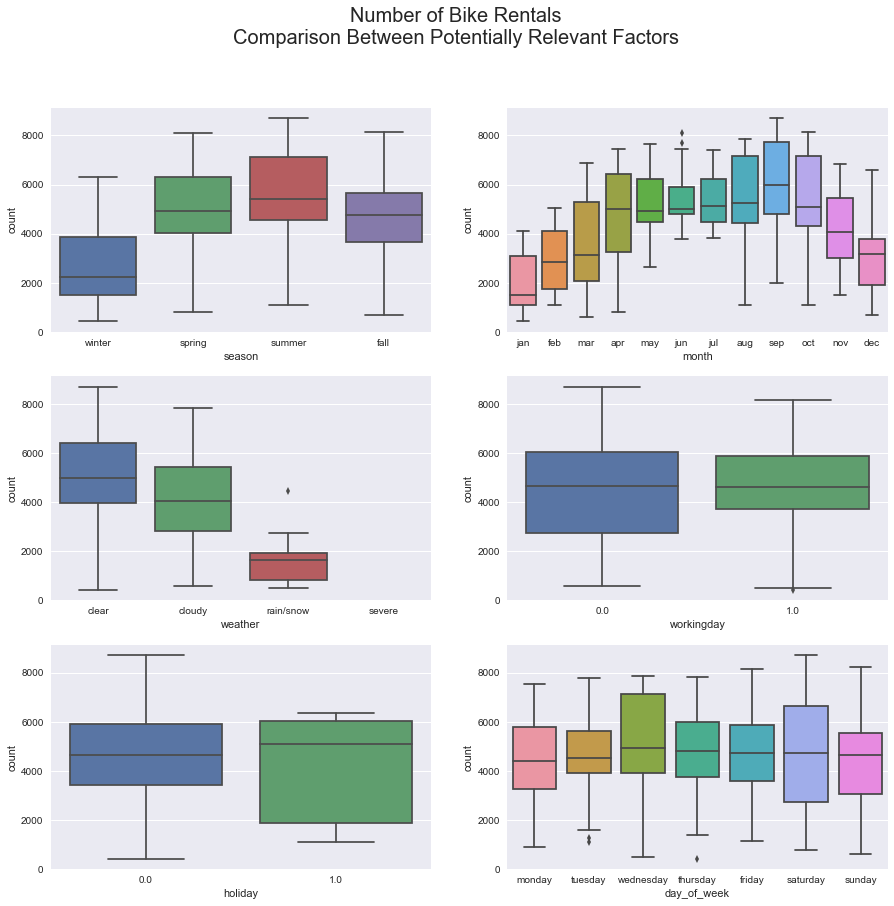

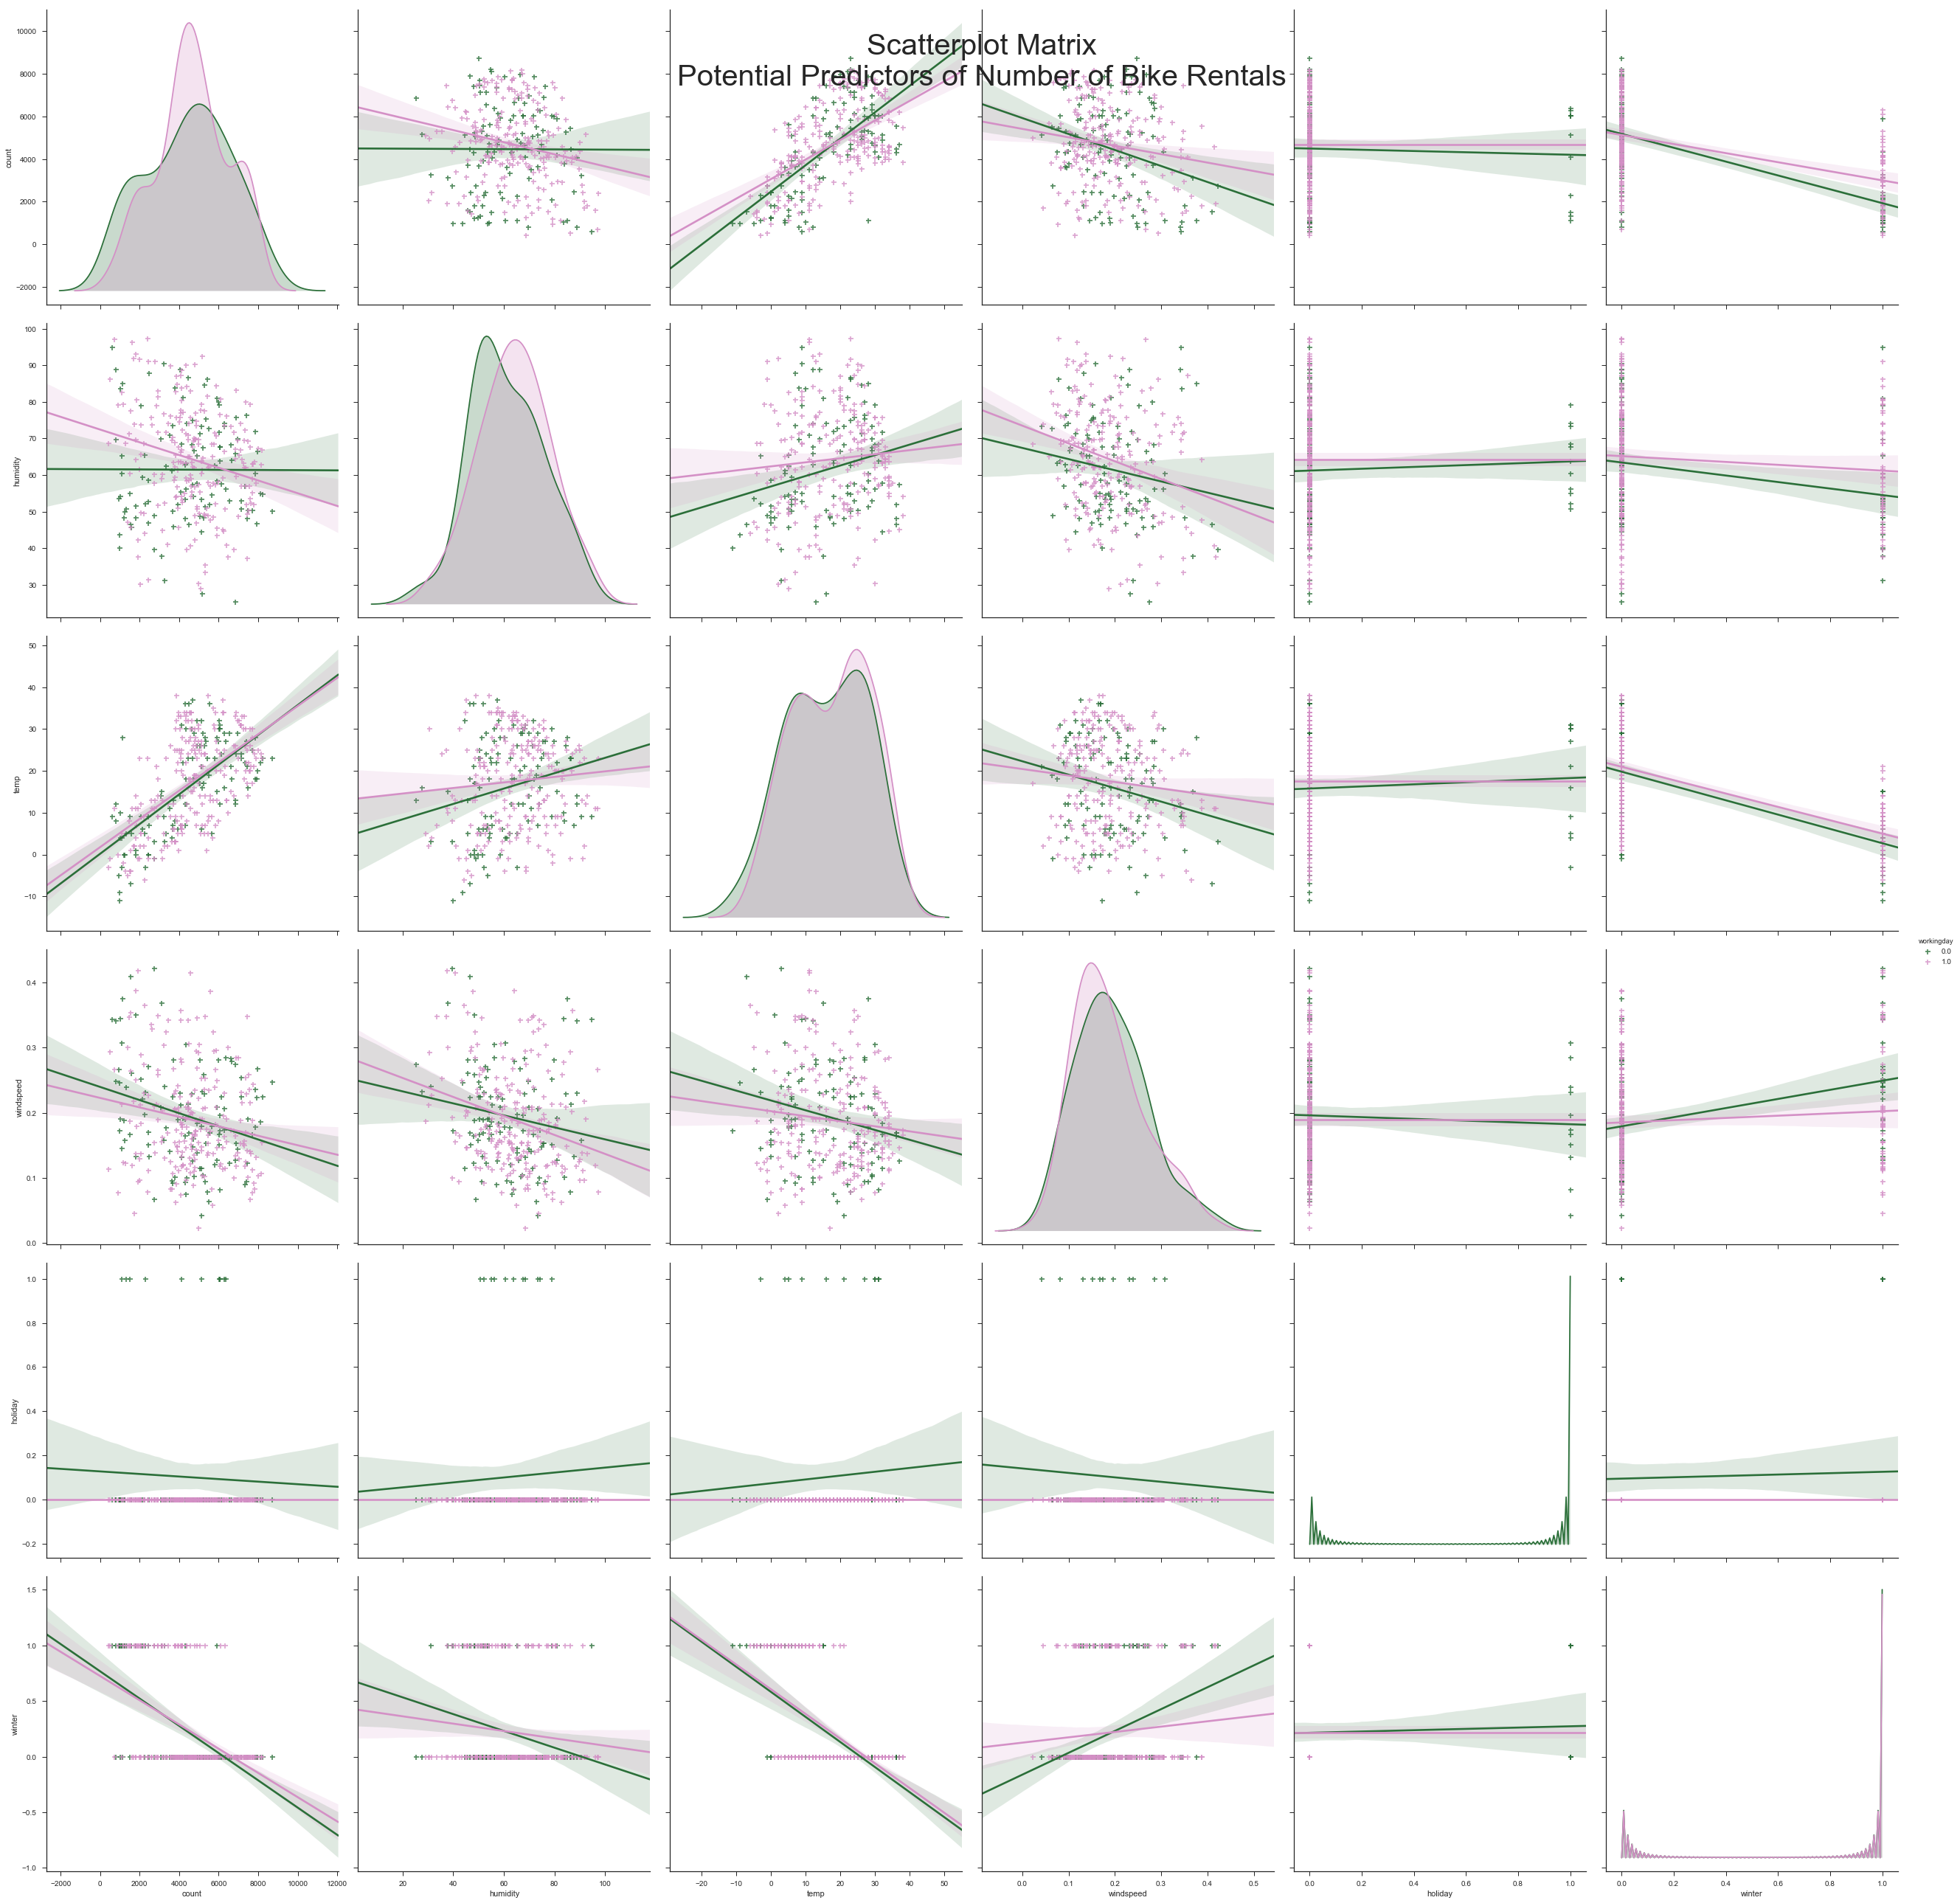

In [3]:
import seaborn as sns
factors = ['season', 'month', 'weather', 'workingday', 'holiday', 'day_of_week']

# generate 3 axes of 2 plots, iterate over the factors to plot boxplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 2, sharey=False, figsize=(15, 14))
for i, factor in enumerate(factors):
    if i < 2:
        sns.boxplot(y='count', x=factor, ax=ax1[i], data=df_train)
    elif i < 4:
        sns.boxplot(y='count', x=factor, ax=ax2[i-2], data=df_train)
    else:
        sns.boxplot(y='count', x=factor, ax=ax3[i-4], data=df_train)
        fig.suptitle('Number of Bike Rentals\nComparison Between Potentially Relevant Factors', fontsize=20)
    #sns.swarmplot(x=df_train.workingday.astype(str), y=df_train['count'].values, alpha=0.3)

sns.set(style='ticks')
sns.pairplot(data=df_train, vars=['count','humidity','temp','windspeed','holiday','winter'], \
             hue='workingday', palette='cubehelix', diag_kind='kde', kind='reg', size=6, \
             diag_kws=dict(shade=True), markers="+")
plt.suptitle('Scatterplot Matrix\nPotential Predictors of Number of Bike Rentals', fontsize=40)

### Exploratory Analysis

Based on the training data the number of bike rentals appears to have relationships with several continuous and categorical variables. 

The season appears to have a considerable relationship with the number of rentals. As logic would follow, this relationship is mirrored in each season's concomitant months. Bike rentals appear to peak in the warmest months/seasons and hit a low in the coolest months/seasons.

The training data shows that there are fewer rentals on average when the day is categorized as rainy or snowy. There is a slight difference between cloudy and clear days, but at first glance the difference does not appear significant.  It appears that the severe weather days are not represented in the training data. While this fact will lead to an over-paramaterized model with respect to the Season category, it will be inconsequential since no signal will come through in the model. This absence might need further investigation.

While there is more variation on Holidays, based on the boxplot above it does not appear that Holidays have a significant impact on the number of rentals. It is interesting that the lower end of the distribution is lower than non-Holidays, yet the median number of rentals is higher. The same appears true for Day of Week and Working Day -- the variation changes a bit from day-to-day, yet the distribution appears similar as is evidenced by the boxplots. 

Temperature appears to have a positive correlation with the number of bike rentals, while Windspeed appears to have a negative correlation with the number of bike rentals, as evidenced in the scatterplot matrix above. Both of these variables appear to have considerable noise when plotted against the number of rentals, and are clearly insufficient alone to produce reliable estimates.

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

In [4]:
# importing StandardScaler from sklearn to preserve mean/sd from training data
from sklearn.preprocessing import StandardScaler

# id scale columns and rename new columns
cols_to_scale = ['temp', 'atemp', 'humidity', 'windspeed']
scale_cols = ['scaled_'+str(col) for col in cols_to_scale]

for col, new_col in zip(cols_to_scale, scale_cols):
    # fitting scaler with training data
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(df_train[col].values.reshape(-1, 1))
    
    # centering both train and test data using the training mean and std dev
    df_train[new_col] = scaler.transform(df_train[col].values.reshape(-1, 1))
    df_test[new_col] = scaler.transform(df_test[col].values.reshape(-1, 1))

# drop raw categorical and continuous columns in preparation for ML algorithms
drop_cols = ['season', 'month', 'weather', 'day_of_week', 'temp', 'atemp', 'humidity', 'windspeed']
df_train = df_train.drop(drop_cols, axis=1)
df_test = df_test.drop(drop_cols, axis=1)
df_train.head()

,holiday,workingday,count,friday,monday,saturday,sunday,thursday,tuesday,wednesday,...,jun,mar,may,nov,oct,sep,scaled_temp,scaled_atemp,scaled_humidity,scaled_windspeed
0,0.0,1.0,6073.0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0.624743,0.651090,0.922058,-0.930164
1,0.0,1.0,6606.0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,-0.180583,-0.054841,0.697907,-0.213825
2,0.0,1.0,7363.0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0.803704,0.852785,-0.449062,0.805143
3,0.0,0.0,2431.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,-1.522794,-1.567551,-0.332616,-0.269507
4,0.0,1.0,1996.0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0.535262,0.348548,1.978781,-1.200843


### Converting Categorical Attributes

Categorical attributes cannot be used directly as predictors for several reasons. Firstly, they represent discrete categories that are not always ordinal in nature -- which is especially relevant when the categories are encoded into numerical proxies. Secondly, these categories are often supplied as text strings as opposed to ordinal numbers (such as provided with `season`). 

This data set has two factor variables that are already encoded into a binary form: `holiday` and `workingday`. However there are other categorical variables that are encoded in a $1 ... N$ or $0...N-1$ sequence: `season`, `month`, `day_of_week` and `weather`. While it may be tempting to preserve the $1 ... N$ format of this data, it risks a special type of lying with data. For example, we cannot say that `day_of_week == 0` (Monday) will have no effect whatsoever on our $Y$ label *a priori*, however if we were to maintain the data as-is where Monday has a value of 0 then the affect of Mondays will be lost. Further, we have no basis for the assumption that `season == 1` (Spring) will have half the impact of `season == 2` (Summer). 

One-hot encoding is used to deal with this potentially confusing problem. $K_j - 1$ predictors are introduced for each factor $j \in J$ as binary variables. The reason $K_j - 1$ predictors are used is because, in a mutually exclusive and collectively exhaustive set of categories for each factor variable $j$, we can logically make the assumption that when all of the binary categories in $K_j$ that are explicitly accounted for as columns are equal to 0 that the category that was not explicitly accounted for is equal to one. For example, if `is_spring = is_summer = is_fall = 0`, we can assume that the category that was left out `is_winter` is equal to one.

### Scaling & Centering $X$

Scaling and centering continuous predictors can yield computational efficiencies, especially when attributes are in different scales. It may also improve the interpretability of coefficients. Above the training mean and standard deviation were used to scale the continuous $X$ predictors around zero using a standard z-score transformation of $\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$. Testing data is deliberately left out of this calculation so that the regression training has no affiliation whatsoever with the testing data.

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [5]:
from sklearn.linear_model import LinearRegression
from scipy import stats

all_predictors = [col for col in df_train.columns if col != 'count']

x_train, y_train = df_train[all_predictors], df_train['count']
x_test, y_test = df_test[all_predictors], df_test['count']

def sm_linear_regression(X, Y, intercept=True):
    '''
    Inputs
    --------------------------------------
    X: np.array, np.ndarray, pd.Series or pd.DataFrame object of predictors
    Y: np.array or pd.Series object of labels
    intercept: default True, use False if no interecept desired
    
    Outputs
    --------------------------------------
    lin_model_results: statsmodels.linear_regression.OLS.fit object
    '''
    if intercept: X = sm.add_constant(X)
    
    lin_model = sm.OLS(Y, X)
    lin_model_results = lin_model.fit()
    
    return lin_model_results

linear_model_all = sm_linear_regression(x_train, y_train)
print(linear_model_all.summary())

# add constant to x_test for statsmodels.linear_regression.OLSresults.predict
x_test_all, x_train_all = add_constant(x_test), add_constant(x_train)

r2_train_all = r2_score(y_train, linear_model_all.predict(x_train_all))
r2_test_all = r2_score(y_test, linear_model_all.predict(x_test_all))

print('''
R-squared on training data = %.4f
R-squared on testing data = %.4f
''' %(r2_train_all, r2_test_all))

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     15.25
Date:                Wed, 04 Oct 2017   Prob (F-statistic):           6.56e-42
Time:                        19:55:06   Log-Likelihood:                -2832.1
No. Observations:                 331   AIC:                             5720.
Df Residuals:                     303   BIC:                             5827.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2025.7149    104.153  

Significant coefficients using a two-tailed t-test:

                   coefficient       p_value    t_value
coefficients                                          
const             2025.714912  3.000843e-55  19.449412
workingday         628.314191  1.688188e-05   4.372844
saturday           913.370478  5.168551e-07   5.130533
sunday             448.225468  8.350273e-03   2.654991
fall               943.140981  2.706327e-03   3.024188
summer             749.836014  1.697287e-02   2.400560
clear             1208.086593  7.876655e-10   6.349658
cloudy            1191.520009  4.019260e-13   7.588395
jul               -997.191887  2.596357e-02  -2.237756
oct                769.046023  4.900176e-02   1.976526
sep                687.939685  3.841500e-02   2.079468
scaled_humidity   -547.663783  2.020827e-06  -4.845341
scaled_windspeed  -254.736916  1.744235e-03  -3.158772


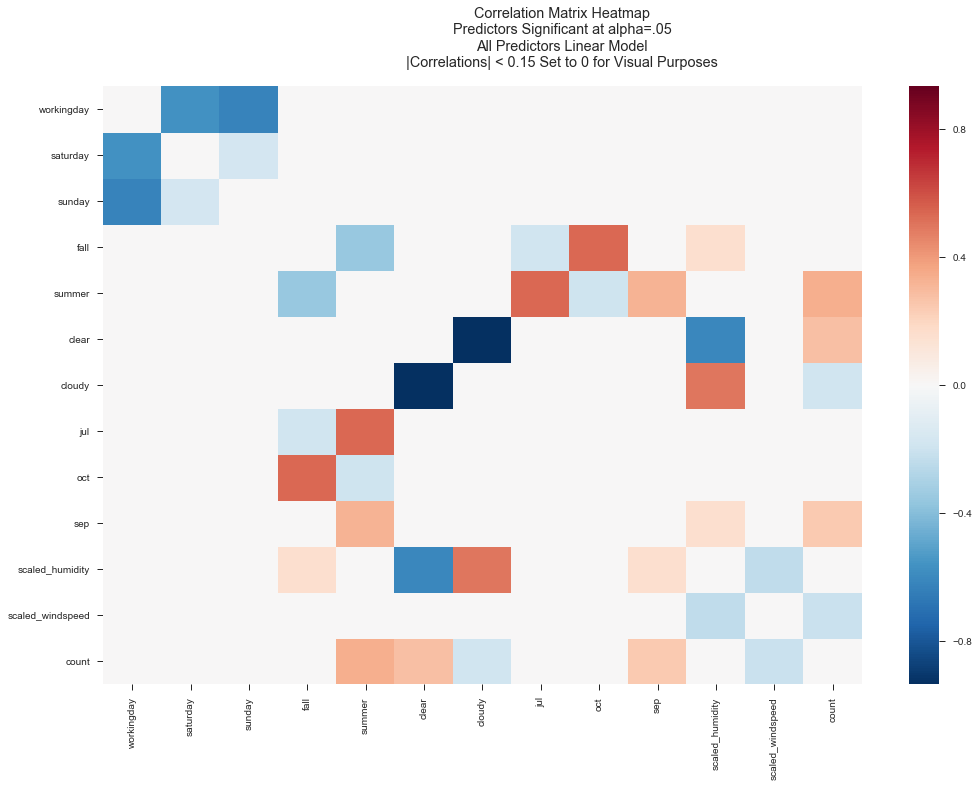

In [6]:
def significant_coef_twotail_t(linear_model, alpha):
    '''
    Extracts significant coefficients of a linear model at alpha
    by performing a t-test on a statsmodels.linear_regression.OLSresults object
    
    Inputs
    --------------------------------------
    linear_model: statsmodels.OLS.fit object
    alpha: significance level to be split among both tails
    
    Outputs
    --------------------------------------
    sig_coef_df: pd.DataFrame object containing t-value, p-value, and coefficients
    '''
    # get coefficients, degrees of freedom, p-values and t-values
    coefficients = linear_model.params
    df_lm_all = len(linear_model.resid) - len(coefficients) - 1#linear_model.df_model
    t_values = linear_model.tvalues
    p_values = linear_model.pvalues

    # acquire critical t-value (by splitting alpha for two-tails) to filter and check significance
    split_alpha = alpha / 2
    critical_t = stats.t.isf([0 + split_alpha, 1 - split_alpha], df=df_lm_all)

    # organize coefficient info into pd.DataFrame class; filter out non-significant
    coef_df = pd.DataFrame({'coefficient':coefficients, 't_value':t_values, 'p_value':p_values})
    coef_df.index.name = 'coefficients'
    #coef_df['significant_p'] = coef_df.p_value < alpha; print(coef_df[coef_df.significant_p == False])
    sig_coef_df = coef_df[(coef_df.t_value < min(critical_t)) | (coef_df.t_value > max(critical_t))]
    
    return sig_coef_df

sig_coef_df = significant_coef_twotail_t(linear_model_all, alpha=.05)
print('Significant coefficients using a two-tailed t-test:\n\n', sig_coef_df)

# get significant column names
sig_model = [col for col in sig_coef_df.index.values.tolist() if col != 'const'] + ['count']

# create correlation matrix to see what is related to `count`
sig_model_corr = df_train[sig_model].corr()

# mute low abs values for correlation
np.fill_diagonal(sig_model_corr.values, np.zeros(len(sig_model_corr)))
sig_model_corr[abs(sig_model_corr) < .15] = 0

fig, ax = plt.subplots(figsize=(17,11))
sns.heatmap(sig_model_corr)
plt.suptitle('Correlation Matrix Heatmap\nPredictors Significant at alpha=.05\nAll Predictors Linear Model\n|Correlations| < 0.15 Set to 0 for Visual Purposes')

Outlier before:
    scaled_temp scaled_atemp
188     1.25111     -1.56755

Outlier after:
scaled_temp    -1.54231
scaled_atemp   -1.56755
Name: 188, dtype: object


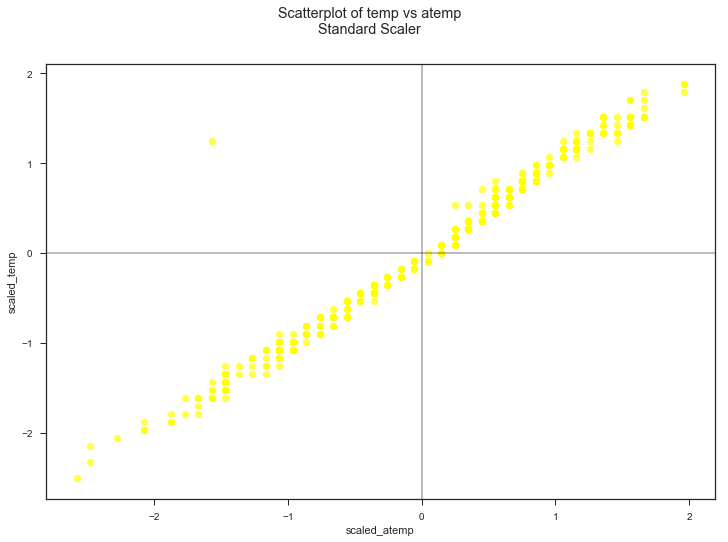

In [7]:
# plot temp atemp relationship
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(df_train.scaled_atemp, df_train.scaled_temp, c='yellow', alpha=.7)
plt.axhline(0, c='black', alpha=0.3)
plt.axvline(0, c='black', alpha=0.3)
plt.suptitle('Scatterplot of temp vs atemp\nStandard Scaler')
plt.ylabel('scaled_temp')
plt.xlabel('scaled_atemp')

# identify which index contains outlier
print('Outlier before:')
print(x_train.loc[(x_train.scaled_temp > 0) & (x_train.scaled_atemp < -1), ['scaled_temp','scaled_atemp']].astype(pd.Series))

# impute outlier using simple regression using index acquired above
temperature_imputer_model = sm_linear_regression(x_train.scaled_atemp, x_train.scaled_temp, False)
x_temperature = x_train.loc[188, 'scaled_atemp']
y_temperature = temperature_imputer_model.predict(x_temperature)
x_train.at[188, 'scaled_temp'] = y_temperature

# verify all is good in the world of scaled_temp
print('\nOutlier after:')
print(x_train.loc[188, ['scaled_temp','scaled_atemp']].astype(pd.Series))

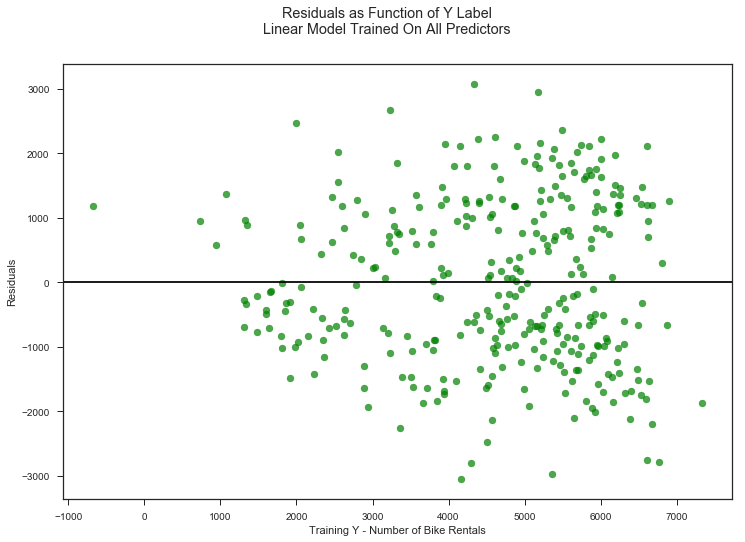

In [8]:
# get residuals
lm_all_resid = linear_model_all.resid
x_train_withintercept = add_constant(x_train)
yhat_all = linear_model_all.predict(x_train_withintercept)

# plot residuals
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(yhat_all, lm_all_resid, c='green', alpha=.7, label='residuals')
plt.axhline(0, c='black')
plt.suptitle('Residuals as Function of Y Label\nLinear Model Trained On All Predictors')
plt.ylabel('Residuals')
plt.xlabel('Training Y - Number of Bike Rentals')

### Predictors Related to `count`

Based on the correlation matrix (visualized in the heatmap above), the Y label `count` appears to have a relatively strong positive correlation with `summer`, `clear` and `sep`.

The variables `workingday` and its converse measurements of `sat` and `sun` have significant relationships with the Y `count` variable. However the coefficients on all three of these variables is positive, counter to intuition that `workingday` may lead to lower (or higher) numbers of rentals than weekend days. 

Months that are significant at the $\alpha = .05$ level in predicting `count` include `jul`, `oct` and `sep`. While `jul` has a negative relationship with `count` (as evidenced by its coefficient printed above), both `sep` and `oct` have a positive coefficients. 

The binary variable for `holiday` does not have a significant relationship with `count` at the $\alpha = .05$ level, consistent with the exploratory boxplots generated above.

### Differences Between `temp` and `atemp`

The scatterplot above between `scaled_temp` and `scaled_atemp` shows definitively that these two measurements are more-or-less measuring the same phenomenon, temperature. Including both in a model would be redundant and introduce co-linearity. The scatterplot also unveils an outlier in the `scaled_temp` variable. This one data point is imputed using the regression model of `scaled_atemp` regressed on `scaled_temp` due to their almost perfect relationship.

### Plot of Residuals Against $\hat Y$

When plotted as a function of the training $\hat Y$ values, the model fitted on all predictors returns residuals that indicate no linear relationship with the residual errors. The error term in the in an Ordinary Least Squares model is constructed to be uncorrelated with the observed values of $X$. This fact will be true even if bias exists in the model, or if some other assumption is violated. Due to this fact, and since $\hat Y$ is a function of the $X$ covariates, $\hat Y$ will also be uncorrelated with the error term. 

It is interesting to note, however, that the variance appears to increase at larger values of $\hat Y$. This may be indicative that the assumption of homoskedasticity is violated. Further review of the data is warranted to verify this conjecture.

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

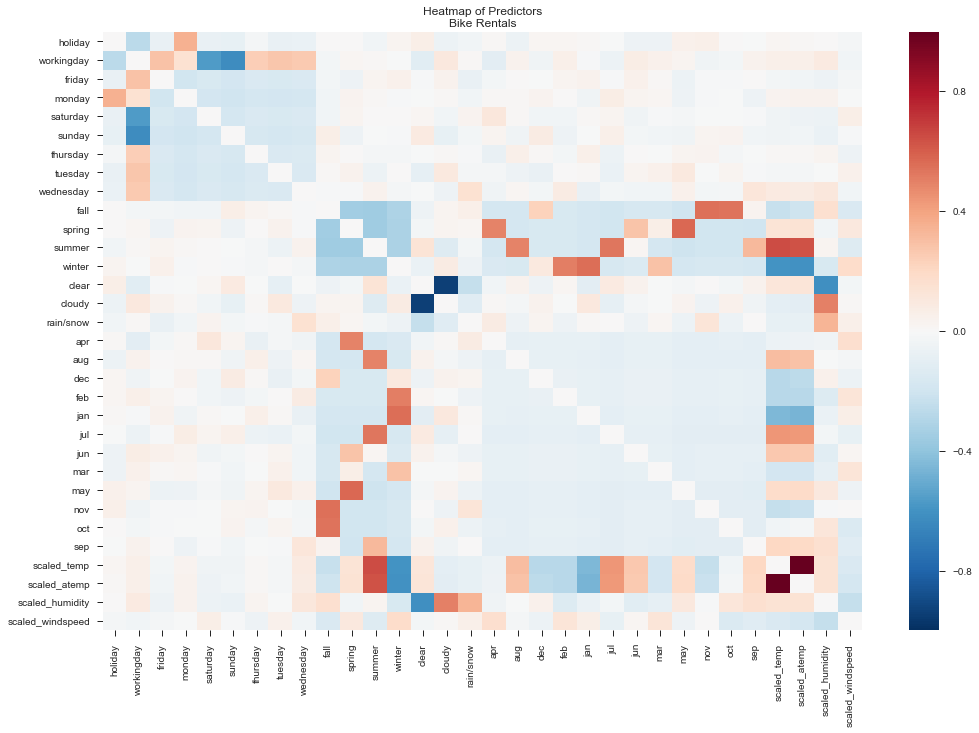

In [9]:
# use pandas' pd.DataFrame.corr function to compute Pearson correlations
corr_matrix = x_train.corr()
np.fill_diagonal(corr_matrix.values, np.zeros(len(corr_matrix)))

fig, ax = plt.subplots(figsize=(17,11))
sns.set_palette('coolwarm')
sns.heatmap(corr_matrix)
plt.title('Heatmap of Predictors\nBike Rentals')

### Assessment of Collinearity Among $X$

- `fall` has a strong positive correlation with `nov`, `oct`, and `sep`
- `spring` has a strong positive correlation with `apr`, `may` and `jun`
- `summer` has a strong positive correlation with `scaled_temp` and `scaled_atemp`, as well as a strong positive correlation with `jul` and `aug`
- `winter` has a strong negative correlation with `scaled_temp` and `scaled_atemp`, as well as a strong positive correlation with `dec`, `jan` and `feb`
- `workingday` has a strong negative correlation with `sat` and `sun`, and the converse is true for weekdays
- `clear` has a strong negative correlation with `scaled_humidity` and `cloudy`
- `rain/snow` has a strong positive correlation with `scaled_humidity`

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [10]:
def get_bic(X, Y):
    '''
    Takes (X, Y) as inputs
    Trains statsmodels.linear_regression.OLS model
    Derives BIC for reference
    '''
    X = add_constant(X)
    model = sm.OLS(Y, X).fit()
    return model.bic

def forward_selection(x_train, y_train):
    '''
    Inputs
    --------------------------------------
    x_train: pd.DataFrame object containing ALL features in the X set
    y_train: pd.Series or np.array object containing labels
    
    Outputs
    --------------------------------------
    best_predictor_set: a list of columns determined to have the lowest BIC
    linear_model: model trained on the entire x_train dataset for later use
    '''
    all_predictors = x_train.columns
    predictors = [([], 0)]

    linear_model = LinearRegression(fit_intercept=True)
    
    # iteratively build up the predictor set
    for k in range(1, len(all_predictors)):
        best_k_minus_1 = predictors[-1][0]
        new_predictors = list(set(all_predictors) - set(best_k_minus_1))
        bics = []

        for predictor in new_predictors:
            k_predictors = best_k_minus_1 + [predictor]
            x_train_fwd = df_train[k_predictors].values

            if k == 1:
                x_train_fwd = x_train_fwd.reshape((-1, 1))

            linear_model.fit(x_train_fwd, y_train)
            bics.append(get_bic(x_train_fwd, y_train))

        best_k = best_k_minus_1 + [new_predictors[np.argmin(bics)]]
        predictors.append((best_k, np.min(bics)))

    linear_model.fit(x_train, y_train)
    predictors.append((all_predictors, get_bic(x_train, y_train)))
    
    # derive best predictor set and fit training model
    best_predictor_set = sorted(predictors, key=lambda t: t[1])[1]
    X_train = x_train[best_predictor_set[0]].values
    linear_model.fit(X_train, y_train)

    return best_predictor_set[0], linear_model

fwd_predictor_set, linear_model_fwd = forward_selection(x_train, y_train)

r2_train_fwd = linear_model_fwd.score(x_train[fwd_predictor_set], y_train)

print('''
Forward Selection 
Features: %s
R-squared training = %.4f
''' %(fwd_predictor_set, r2_train_fwd))


Forward Selection 
Features: ['scaled_atemp', 'scaled_humidity', 'winter', 'rain/snow', 'sep', 'oct', 'scaled_windspeed', 'jul']
R-squared training = 0.5483



In [11]:
# backwards step-wise selection
def backward_selection(x_train, y_train):
    '''
    Inputs
    --------------------------------------
    x_train: pd.DataFrame object containing ALL features in the X set
    y_train: pd.Series or np.array object containing labels
    
    Outputs
    --------------------------------------
    best_predictor_set: a list of columns determined to have the lowest BIC
    linear_model: model trained on the entire x_train dataset for later use
    '''
    linear_model = LinearRegression(fit_intercept=True)
    all_predictors = x_train.columns
    x_train_bwd = x_train.copy()
    predictors = [(all_predictors, get_bic(x_train_bwd, y_train))]

    for k in range(len(all_predictors), 1, -1):
        best_k_predictors = predictors[-1][0]
        bics = []

        for predictor in best_k_predictors:
            # defining newest set of predictors, then selecting out of x_train
            k_minus_1 = list(set(best_k_predictors) - set([predictor]))
            x_train_bwd = x_train[k_minus_1].values
            
            ## calling the `get_bic` function defined above, fitting ols and returning bic
            bics.append(get_bic(x_train_bwd, y_train))

        best_k_minus_1 = list(set(best_k_predictors) - set([best_k_predictors[np.argmin(bics)]]))
        predictors.append((best_k_minus_1, np.min(bics)))

    # id best predictor set
    best_predictor_set = sorted(predictors, key=lambda t: t[1])[0]

    X_train = x_train[best_predictor_set[0]].values
    linear_model.fit(X_train, y_train)

    return best_predictor_set[0], linear_model

bwd_predictor_set, linear_model_bwd = backward_selection(x_train, y_train)

linear_model_bwd = LinearRegression(fit_intercept=True)
linear_model_bwd.fit(x_train[bwd_predictor_set], y_train)

r2_train_bwd = linear_model_bwd.score(x_train[bwd_predictor_set], y_train)
r2_test_bwd = r2_score(y_test, linear_model_bwd.predict(x_test[bwd_predictor_set]))

print('''
Backward Selection
Features: %s
R-squared training = %.4f
''' %(bwd_predictor_set, r2_train_bwd))


Backward Selection
Features: ['scaled_atemp', 'sep', 'rain/snow', 'scaled_humidity', 'scaled_windspeed', 'winter']
R-squared training = 0.5270



### Step-Wise Selection: Forward vs. Backward

Both methods were reviewed to get a feel for their differences, and each will be discussed in-turn. The features selected by both of these methods had considerable overlap except:
    
    - Forward Selection chose `jul` where Backward Selection did not
    - Backward Selection chose `cloudy` & `clear` where Forward Selection did not

Forward Selection chose 8 predictors while Backward Selection chose 9.

### Forward Step-Wise Selection Interpretation

Intuitively it is hypothesized that Forward Selection will yield a more robust model in highly collinear space (such as this dataset). This is because the model is built up iteratively, as opposed to Backward Selection where the model is disassembled iteratively where it is  more difficult to tease out individual effects from a soup of collinear $X$ variables.

Forward Selection was utilized to iteratively build an optimal set of features for the linear model. Using BIC to identify this set of predictors yields a model that trains on `scaled_atemp`, `scaled_humidity`, `winter`, `rain/snow`, `sep`, `oct`, `scaled_windspeed`, and `jul`. This model yields a training $R^2$ of 0.5483. 

It appears that much of the collinearity was eliminated by employing Forward Selection, which is encouraging. However some still remains: `rain/snow` and `scaled_humidity` have a strong relationship, as does `winter`, `jul` and `scaled_atemp`. However these effects may be dampened when holding the other variables constant.

### Backward Selection Interpretation

Conversely to Forward Selection's intuition, it is hypothesized that Backward Selection will yield a less robust model than Forward Selection due to the highly collinear nature of this dataset. This is because the null model begins with all predictors, making the iterative approach less effective at teasing out individual effects of any given variable.

Using BIC as the evaluation criteria, Backward Selection yielded a model that trains on `sep`, `scaled_atemp`, `winter`, `scaled_humidity`, `scaled_windspeed`, `rain/snow`, `oct`, `cloudy`, and `clear`. This feature set yielded a training $R^2$ of 0.5402. 

It does not appear that all of the collinearity was eliminated using Backward Selection. `cloudy` and `clear` logically have a strong negative correlation since both states of being cannot occur at the same time. Likewise, `scaled_humidity` has a strong positive relationship with `rain/snow` and a strong negative relationship with `clear`. Finally, `scaled_atemp` and `winter` naturally have a strong negative relationship.

### Comparison with All Predictors Model

While the training $R^2$ for the model trained on all of the predictors yielded a value of 0.5761 (higher than both Forward and Backward Selection) it is important to note that $R^2$ is a poor measurement of the merits of such a "kitchen sink" model. On any linear regression model $R^2$ will always increase the more predictors are added due to the nature of its calculation. This means that the $R^2$ we observe on the training set is unvalidated in the wild, and not much stock should be placed in it for decision making.

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Fit each of the 3 models on the provided left out test set and calculate $R^2$.  Do the results agree with the cross-validation?  Why or why not?


Cross-validation Score Avg
-------------------------
r2_all    0.413687
r2_bwd    0.450944
r2_fwd    0.467622
dtype: float64


/Users/pmw/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.



          r2_all     r2_bwd     r2_fwd
count  10.000000  10.000000  10.000000
mean    0.413687   0.450944   0.467622
std     0.213997   0.173025   0.169403
min     0.027722   0.144035   0.179230
25%     0.263955   0.360140   0.326394
50%     0.497468   0.529978   0.528824
75%     0.575061   0.563769   0.598963
max     0.607619   0.622308   0.632027

Testing R-squared
-------------------------
All predictors = 0.24934
Forward Selection = 0.26572
Backward Selection = 0.26473



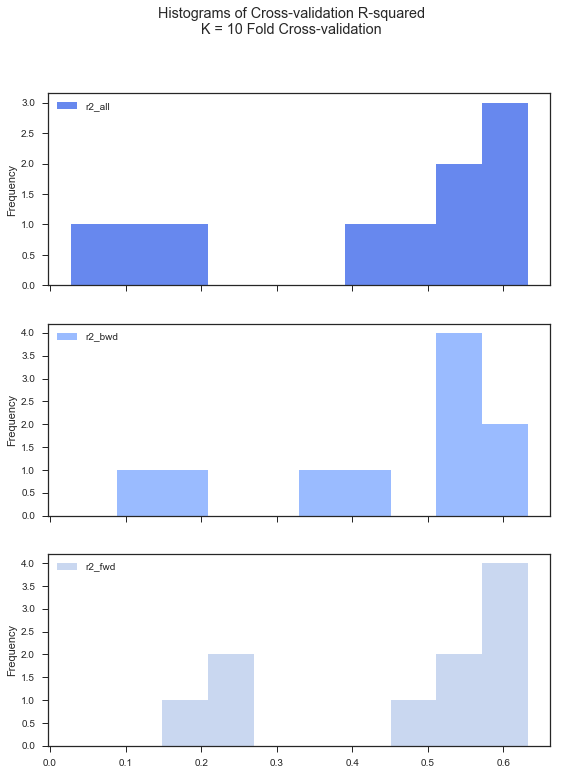

In [12]:
from sklearn.model_selection import KFold

# setting random_state for reproducibility; shuffle=True to ensure sorting effects gone
k_fold = KFold(n_splits=10, random_state=7, shuffle=True)
linear_model = LinearRegression(fit_intercept=True)
r2 = []

for train_indices, test_indices in k_fold.split(x_train):
    # split each fold into a train and validation set
    x_train_kfold, y_train_kfold = x_train.ix[train_indices], y_train.ix[train_indices]
    x_test_kfold, y_test_kfold = x_train.ix[test_indices], y_train.ix[test_indices]
    
    # fit each train fold using the three models
    lm_all = LinearRegression(fit_intercept=True).fit(x_train_kfold, y_train_kfold)
    lm_fwd = LinearRegression(fit_intercept=True).fit(x_train_kfold[fwd_predictor_set], y_train_kfold)
    lm_bwd = LinearRegression(fit_intercept=True).fit(x_train_kfold[bwd_predictor_set], y_train_kfold)
    
    # use validation set to get R2
    r2_all = r2_score(y_test_kfold, lm_all.predict(x_test_kfold))
    r2_fwd = r2_score(y_test_kfold, lm_fwd.predict(x_test_kfold[fwd_predictor_set]))
    r2_bwd = r2_score(y_test_kfold, lm_bwd.predict(x_test_kfold[bwd_predictor_set]))
    
    r2.append({'r2_all':r2_all, 'r2_fwd':r2_fwd, 'r2_bwd':r2_bwd})

cv_scores = pd.DataFrame(r2).mean()
print('''
Cross-validation Score Avg
-------------------------
%s
''' %cv_scores)

r2_df = pd.DataFrame(r2)
r2_df.plot(kind='hist', subplots=True, figsize=(9, 12))
plt.suptitle('Histograms of Cross-validation R-squared\nK = 10 Fold Cross-validation')

print(r2_df.describe())

# fit all three models on test set and report R2 value
x_test_all = add_constant(x_test.values)
r2_test_all = r2_score(y_test, linear_model_all.predict(x_test_all))
r2_test_fwd = r2_score(y_test, linear_model_fwd.predict(x_test[fwd_predictor_set]))
r2_test_bwd = r2_score(y_test, linear_model_bwd.predict(x_test[bwd_predictor_set]))

print('''
Testing R-squared
-------------------------
All predictors = %.5f
Forward Selection = %.5f
Backward Selection = %.5f
''' %(r2_test_all, r2_test_fwd, r2_test_bwd))

### Cross Validation Interpretation

The hypothesis that Forward Selection would yield the best model (when choosing between Forward, Backward and All Predictors) when faced with considerable collinearity is supported by the 10-fold cross-validation performed above.

The average of all of the validation scores for Forward Selection comes in at $R^2 = 0.467622$, slightly higher than Backward Selection's $R^2 = 0.457172$. Both Forward and Backward $R^2$ outperformed the All Predictors model which came in at $R^2 = 0.405440$. The distribution of these scores, as is shown above in the `pd.DataFrame.describe()` table, follows this same ordinal ranking. In further support of Forward Selection, the standard deviation of the 10 $R^2$ values performed on the Forward Selection model was the lowest of the three. 

The outperformance of Forward Selection, though slight, is likely due to the fact that it eliminated more of the collinearity than the other models. 

The final test on the untouched dataset follows this same ordinal ranking as well, with Forward performing best, then Backward, then the All Predictors model. It is interesting that the drop in $R^2$ for all models was drastic (decreasing nearly 50% from their cross-validated training values). This may mean the split between the train and test set may have not been a random split with respect to the underlying distribution of $X$.